## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
# from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

try:
    import dolfin as dl
    using_firedrake = False
except ImportError:
    import firedrake as dl
    using_firedrake = True
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
tStart_notebook = time.time()

## user settings

In [3]:
meshDim = 50 
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 5

eval_mode = "gaussian"

dt = 0.04

## Model problem

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
# fom_transient = FOM_advectiondiffusion(meshDim=meshDim, dt=dt, final_time=4)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000452083s, CPU 0.000614s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0493058s, CPU 0.048568s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.28751e-05s, CPU 5e-06s)
Info    : 2953 nodes 5920 elements
Info    : Writing 'houses.msh'...
Info    : Done writing 'houses.msh'


In [5]:
para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_transient, grid_t = fom.implicit_Euler(m_init=m, dt=dt, final_time=4)
sol_steadystate = fom.solve_steady(forcing=m)

## Measurements

In [6]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters, eval_mode=eval_mode)
pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters)

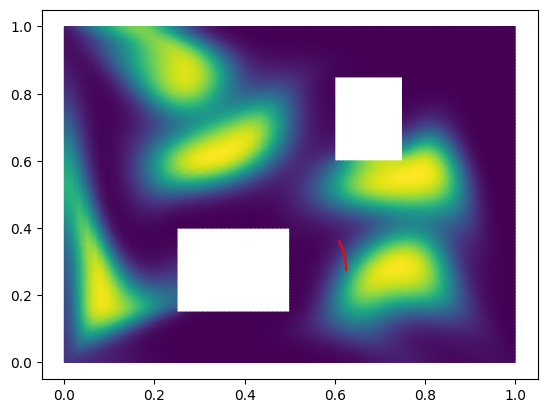

In [7]:
t = 0.5
k = np.argmin(np.abs(grid_t - t))
fom.plot(sol_transient[k])
plt.plot(pos[:k, 0], pos[:k, 1], color="r")

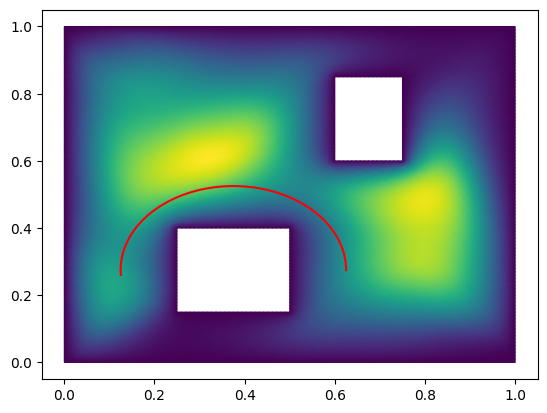

In [8]:
fom.plot(sol_steadystate)
plt.plot(pos[:, 0], pos[:, 1], color="r")

In [9]:
slicer = 1

tStart = time.time()

d_steadystate_gaussian = drone.measure(pos[::slicer, :], sol_steadystate, mode="gaussian")
d_steadystate_pointwise = drone.measure(pos, sol_steadystate, mode="point-eval")
d_steadystate_uniform = drone.measure(pos[::slicer, :], sol_steadystate, mode="uniform")

print("Runtime for half this block: {} min".format((time.time()-tStart)/60))

d_transient_gaussian = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="gaussian")
d_transient_pointwise = drone.measure(pos, sol_transient, mode="point-eval")
d_transient_uniform = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="uniform")

print("Runtime for this block: {} min".format((time.time()-tStart)/60))

/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


Runtime for half this block: 0.55107501745224 min


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison fa

Runtime for this block: 0.892896318435669 min


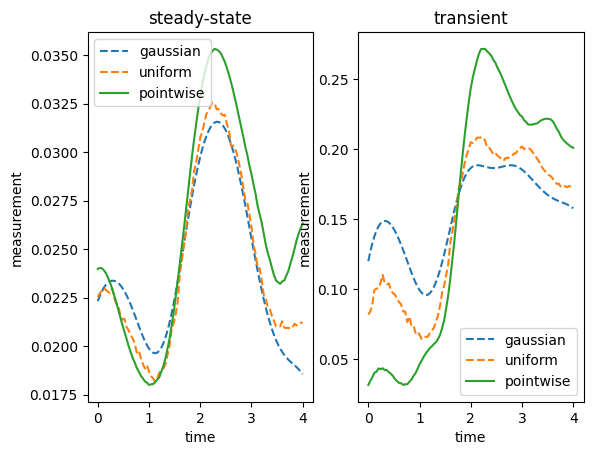

In [10]:
fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t[::slicer], d_steadystate_gaussian, label="gaussian", linestyle = "--")
axs[0].plot(grid_t[::slicer], d_steadystate_uniform, label="uniform", linestyle = "--")
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t[::slicer], d_transient_gaussian, label="gaussian", linestyle = "--")
axs[1].plot(grid_t[::slicer], d_transient_uniform, label="uniform", linestyle = "--")
axs[1].plot(grid_t, d_transient_pointwise, label="pointwise")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

## statistical setup

In [11]:
if eval_mode == "point-eval":
    d_steadystate = d_steadystate_pointwise
    d_transient = d_transient_pointwise
    
if eval_mode == "gaussian":
    d_steadystate = d_steadystate_gaussian
    d_transient = d_transient_gaussian
    
if eval_mode == "uniform":
    d_steadystate = d_steadystate_uniform
    d_transient = d_transient_uniform
    
d_steadystate_pointwise = None
d_transient_pointwise = None

In [12]:
prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))

noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01, noise_seed=42)
noise_model_transient = NoiseModel(grid_t=grid_t, c_scaling=1e+1, c_diffusion = 0.01, noise_seed=42)

brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
brain_transient = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model_transient)

## posterior

In [13]:
print("noise-free data:")

post_steadystate = brain.compute_posterior(data = d_steadystate)
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior(data = d_transient)
print("transient mean:    ", post_transient.mean)

noise-free data:
steady-state mean:  [0.61645171 0.2896447  0.17455723 0.22581845 0.11590522]
transient mean:     [0.07204009 0.02436625 0.01539629 0.02645512 0.01433097]


noisy data:
steady-state mean:  [0.60960697 0.28225187 0.16388148 0.22366507 0.11144082]
transient mean:     [0.07070579 0.02330587 0.01413404 0.02600201 0.01378777]


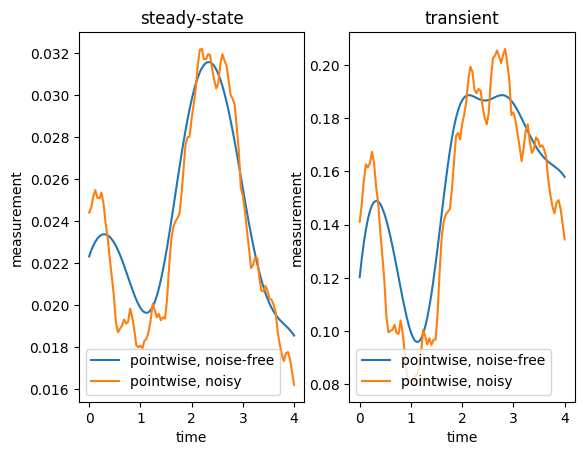

In [14]:
print("noisy data:")

noise = noise_model.sample()

post_steadystate = brain.compute_posterior(data = d_steadystate + noise)
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior(data = d_transient + 10*noise)
print("transient mean:    ", post_transient.mean)


fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t, d_steadystate, label="pointwise, noise-free")
axs[0].plot(grid_t, d_steadystate + noise, label="pointwise, noisy")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t, d_transient, label="pointwise, noise-free")
axs[1].plot(grid_t, d_transient + 10 * noise, label="pointwise, noisy")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

### marginal distribution

In [15]:
noise = noise_model.sample()

mean_steadystate = post_steadystate.compute_mean(data = d_steadystate)
mean_steadystate_noisy = post_steadystate.compute_mean(data = d_steadystate + noise)

mean_transient = post_transient.compute_mean(data = d_transient)
mean_transient_noisy = post_transient.compute_mean(data = d_transient + 10*noise)

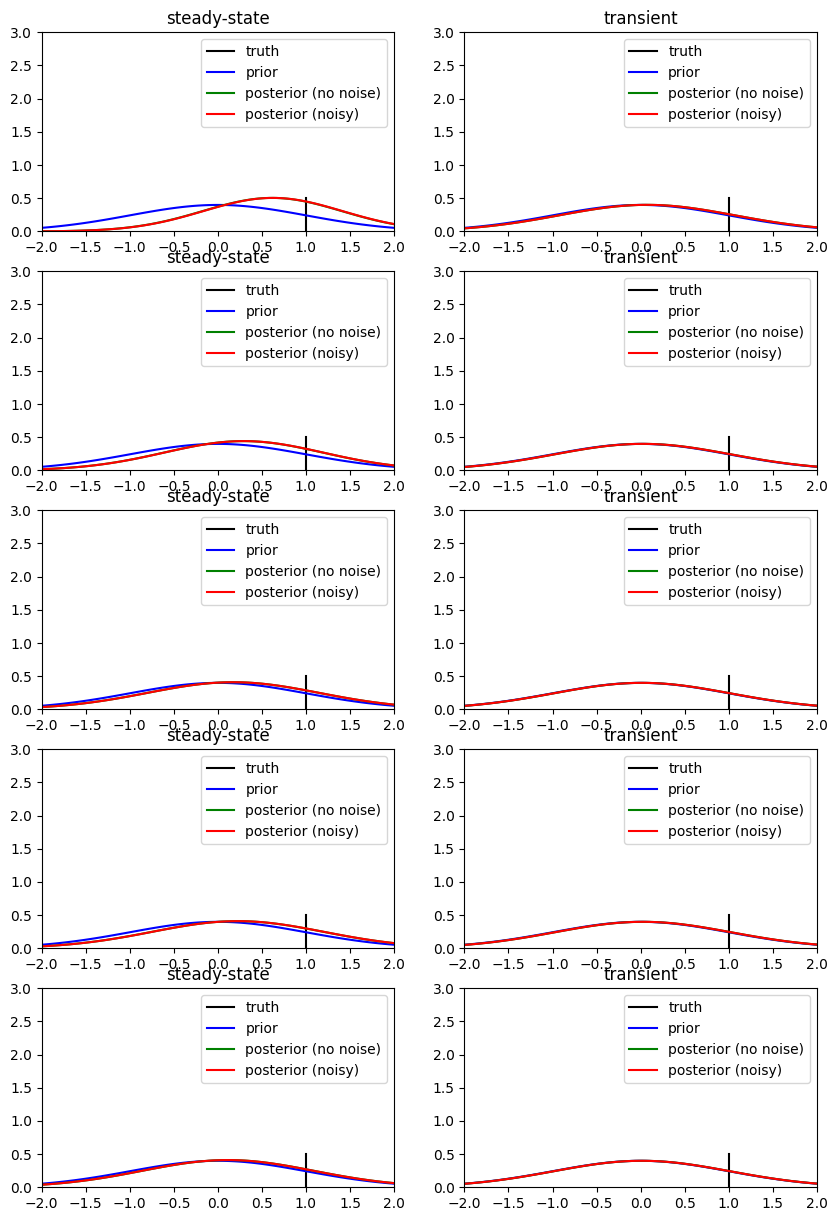

In [16]:
fig, axs = plt.subplots(n_para, 2, figsize = (10, 3*n_para))

for i in range(n_para):
    
    axs[i,0].plot([para_true[i], para_true[i]], [0, 0.5], color="black", label="truth")
    axs[i,1].plot([para_true[i], para_true[i]], [0, 0.5], color="black", label="truth")
    
    variance = prior.covar[i,i]
    sigma = math.sqrt(variance)
    x = np.linspace(prior.mean[i] - 2*sigma, prior.mean[i] + 2*sigma, 100)
    vals = stats.norm.pdf(x, prior.mean[i], sigma)
    axs[i,0].plot(x, vals, label = "prior", color = "b")
    axs[i,1].plot(x, vals, label = "prior", color = "b")
    
    # posterior, steadystate
    variance = post_steadystate.covar[i,i]
    sigma = math.sqrt(variance)
    vals = stats.norm.pdf(x, mean_steadystate[i], sigma)
    axs[i,0].plot(x, vals, label = "posterior (no noise)", color = "g")

    vals = stats.norm.pdf(x, mean_steadystate_noisy[i], sigma)
    axs[i,0].plot(x, vals, label = "posterior (noisy)", color = "r")
    
    # posterior, transient
    variance = post_transient.covar[i,i]
    sigma = math.sqrt(variance)
    vals = stats.norm.pdf(x, mean_transient[i], sigma)
    axs[i,1].plot(x, vals, label = "posterior (no noise)", color = "g")

    vals = stats.norm.pdf(x, mean_transient_noisy[i], sigma)
    axs[i,1].plot(x, vals, label = "posterior (noisy)", color = "r")
    
    
    axs[i,0].set_ylim(0, 3)
    axs[i,1].set_ylim(0, 3)
    axs[i,0].set_xlim(-2, 2)
    axs[i,1].set_xlim(-2, 2)
    axs[i,0].set_title("steady-state")
    axs[i,1].set_title("transient")
    axs[i,0].legend()
    axs[i,1].legend()
    
    #axs[i,i].set_ylim([np.min(vals), 5*np.max(vals_2)])

### Utility functions

In [17]:
print("steady-state:")
print("A-OED:", brain.eval_utility(post_steadystate, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_steadystate, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_steadystate, oed_mode="E"), "\n")

print("transient:")
print("A-OED:", brain.eval_utility(post_transient, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_transient, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_transient, oed_mode="E"), "\n")

steady-state:
A-OED: 4.291039207188624
D-OED: 0.41637927085008114
E-OED: 0.9999662698454291 

transient:
A-OED: 4.988929431450913
D-OED: 0.9889566087714485
E-OED: 0.9999996626871903 



## The End.

In [18]:
t_notebook = time.time() - tStart_notebook
print("Runtime of this notebook: {} min".format(t_notebook / 60))

Runtime of this notebook: 1.2745187958081563 min
